# Imports and device

In [1]:
import sys
import os
sys.path.append(os.path.abspath("src"))
import torch
from src.trainer import Trainer
from src.models import NN_CartPole, NN_Humanoid, NN_Hopper
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("You are using device: %s" % device)

You are using device: mps


# Environment selection

In [2]:
# str_env = "Humanoid-v5"
str_env = "Hopper-v5"
# str_env = "CartPole-v1"

# Configurations and initialisation

In [3]:
updates = {"CartPole-v1": 80, "Humanoid-v5": 1000, "Hopper-v5": 600} # CartPole-v1: [60, 80, 100]
epochs = {"CartPole-v1": 20, "Humanoid-v5": 8, "Hopper-v5": 12} # CartPole-v1: [16, 20, 24] # Hopper-v5: [8, 12, 16] # Humanoid-v5: [6, 8, 10]
N = {"CartPole-v1": 20, "Humanoid-v5": 48, "Hopper-v5": 4} # CartPole-v1: [16, 20, 24] # Hopper-v5: [2, 4, 6] # Humanoid-v5: [40, 48, 56]
T = {"CartPole-v1": 128, "Humanoid-v5": 256, "Hopper-v5": 1024} # CartPole-v1: [64, 128, 256] # Hopper-v5: [512, 1024, 2048] # Humanoid-v5: [128, 256, 512]
batches = {"CartPole-v1": 4, "Humanoid-v5": 4, "Hopper-v5": 16} # CartPole-v1: [2, 4, 8] # Hopper-v5: [8, 16, 32] # Humanoid-v5: [2, 4, 8]
value_loss_coef = {"CartPole-v1": 0.5, "Humanoid-v5": 1.0, "Hopper-v5": 1.0} # CartPole-v1: [0.25, 0.5, 0.75] # Hopper-v5: [0.5, 1.0, 1.5] # Humanoid-v5: [0.5, 1.0, 1.5]
entropy_bonus_coef = {"CartPole-v1": 1e-3, "Humanoid-v5": 1e-5, "Hopper-v5": 5e-5} # CartPole-v1: [5e-4, 1e-3, 5e-3] # Hopper-v5: [1e-5, 5e-5, 1e-4] # Humanoid-v5: [5e-5, 1e-5, 5e-4]
clip_range = {"CartPole-v1": 0.1, "Humanoid-v5": 0.1, "Hopper-v5": 0.1} # CartPole-v1: [0.05, 0.1, 0.5] # Hopper-v5: [0.05, 0.1, 0.5] # Humanoid-v5: [0.05, 0.1, 0.5]
learning_rate = {"CartPole-v1": 5e-4, "Humanoid-v5": 3e-4, "Hopper-v5": 1e-4} # CartPole-v1: [1e-4, 5e-4, 1e-3] # Hopper-v5: [1e-5, 1e-4, 1e-3] # Humanoid-v5: [1e-4, 3e-4, 5e-4]
learning_rate_decay = {"CartPole-v1": 0.999, "Humanoid-v5": 0.99, "Hopper-v5": 0.999} # CartPole-v1: [0.99, 0.999, 0.9999] # Hopper-v5: [0.99, 0.999, 9999] # Humanoid-v5: [0.9, 0.99, 0.999]
reward_scaling = {"CartPole-v1": 0.5, "Humanoid-v5": 0.01, "Hopper-v5": 0.1} # CartPole-v1: [0.1, 0.5, 1.0] # Hopper-v5: [0.05, 0.1, 0.5] # Humanoid-v5: [0.001, 0.01, 0.1]
models = {"CartPole-v1": NN_CartPole, "Humanoid-v5": NN_Humanoid, "Hopper-v5": NN_Hopper}

# Configurations
configs = {
    # Number of updates
    'updates': updates[str_env],
    # Number of epochs to train the model with sampled data.
    'epochs': epochs[str_env],
    # Number of worker processes
    'N': N[str_env],
    # Number of steps to run on each process for a single update
    'T': T[str_env],
    # Number of mini batches
    'batches': batches[str_env],
    # Value loss coefficient.
    'value_loss_coef': value_loss_coef[str_env],
    # Entropy bonus coefficient.
    'entropy_bonus_coef': entropy_bonus_coef[str_env],
    # Clip range.
    'clip_range': clip_range[str_env],
    # Learning rate.
    'learning_rate': learning_rate[str_env],
    # Learning rate decay.
    'learning_rate_decay': learning_rate_decay[str_env],
    # Model to use
    'model': models[str_env](),
    # Device to use for training
    'device': device,
    # Environment to use
    'str_env': str_env,
    # Reward scaling
    'reward_scaling': reward_scaling[str_env]
}

# Initialize the trainer
trainer = Trainer(**configs)

# Optional: load a checkpoint pretrained model and log a video

In [4]:
# # Load checkpoint and save video
# checkpoint = torch.load("checkpoint/" + str_env + "_model.pth", weights_only=True, map_location=device)
# trainer.model.load_state_dict(checkpoint)
# if device != torch.device("cuda:0") or str_env == "CartPole-v1":
#     trainer.log_video(str_env)

# Training without noise

In [5]:
# Run and monitor the experiment
trainer.run_training_loop()

# Stop the workers
trainer.destroy()

  1%|          | 6/600 [00:29<48:11,  4.87s/it]

# Log a video example of your trained agent and save the model's weights

In [ ]:
# Log a video of the trained model
trainer.log_video(str_env)

# Save the model
torch.save(trainer.model.state_dict(), "checkpoint/" + str_env + "_model.pth")

Video recorded with duration 154 frames.
MoviePy - Building video results/Hopper-v5.mp4.
MoviePy - Writing video results/Hopper-v5.mp4



MoviePy - Done !
MoviePy - video ready results/Hopper-v5.mp4


# Make the plottings for your single run

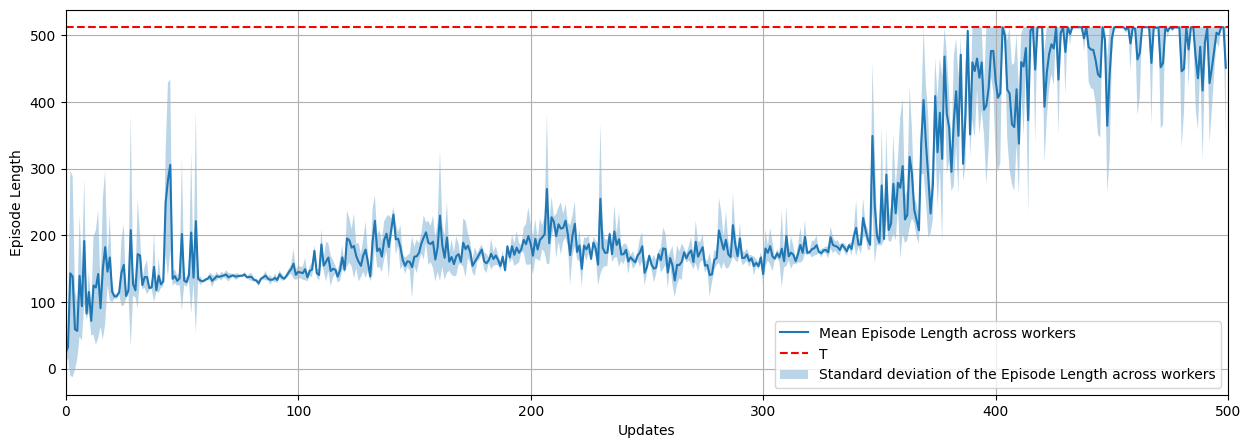

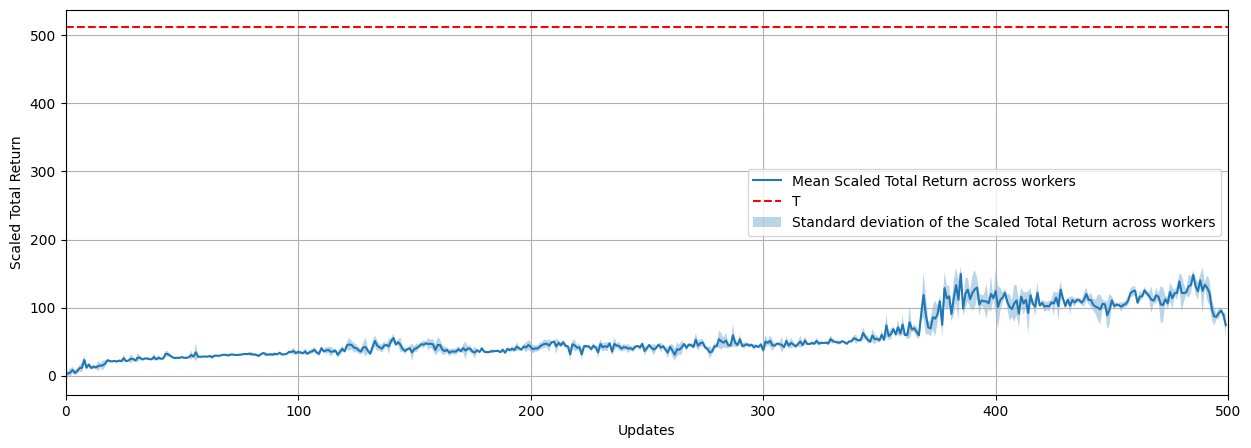

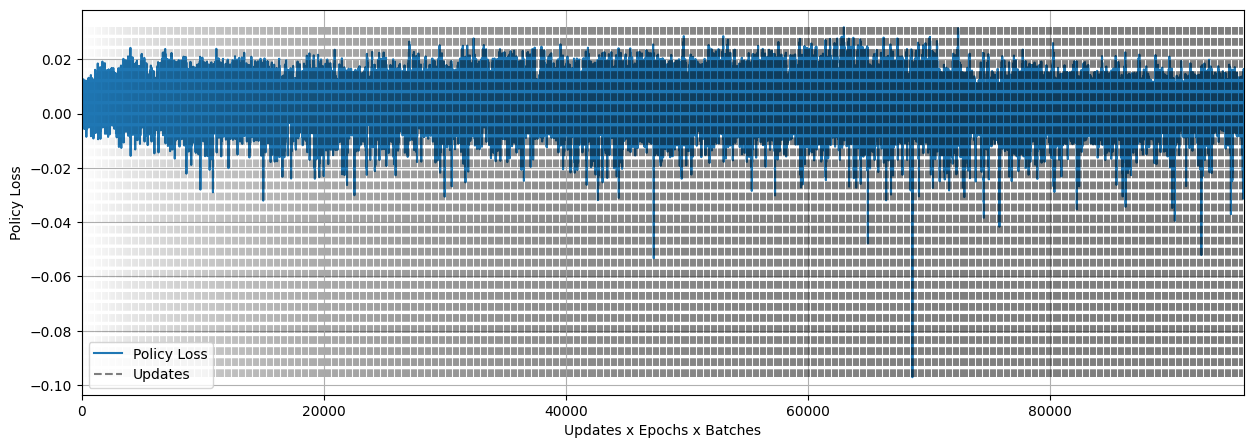

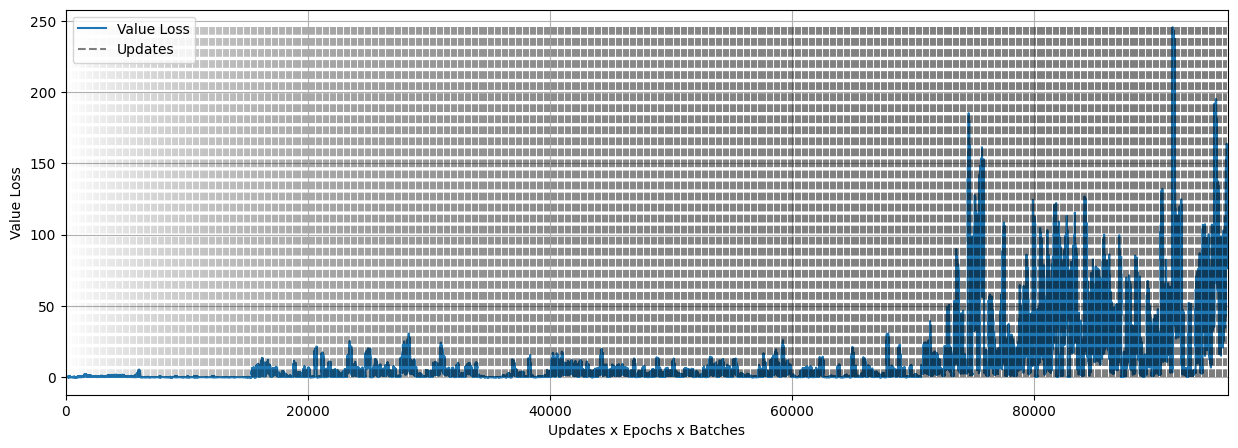

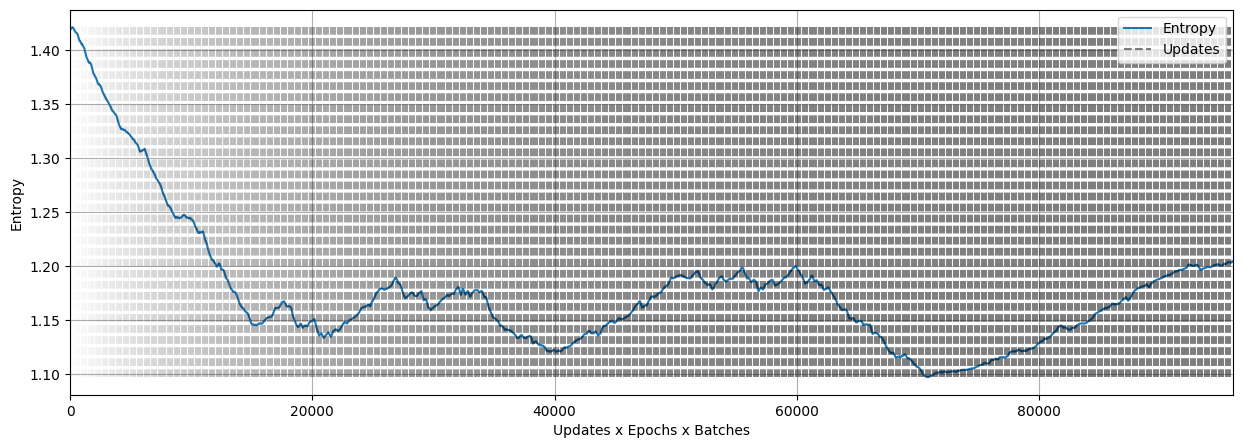

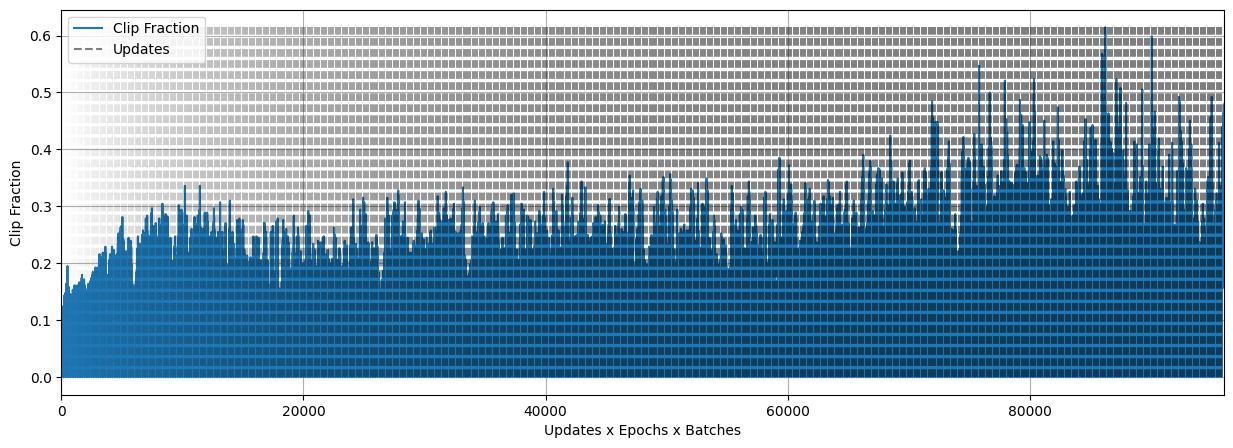

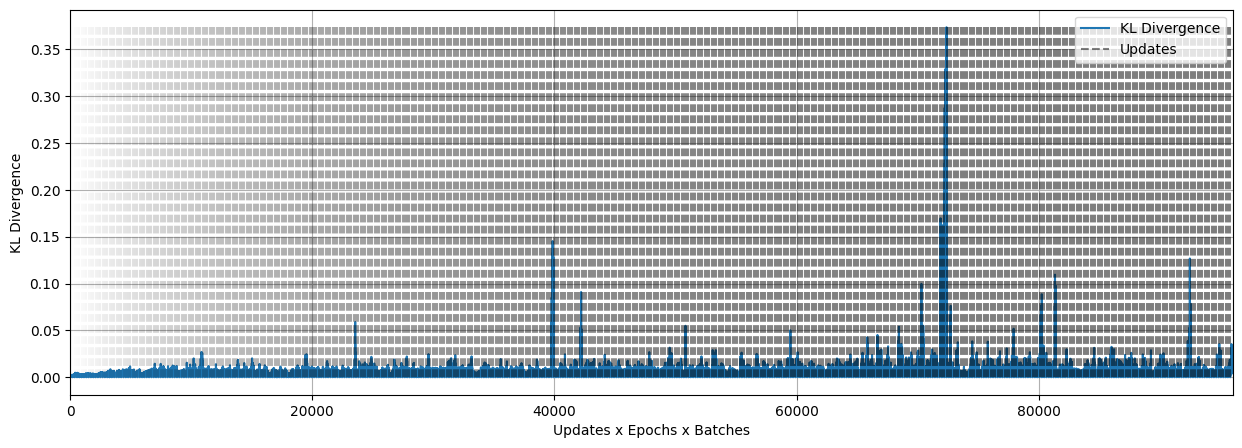

In [ ]:
trainer.plot(str_env)

# Heatmap of the CartPole

In [8]:
if str_env == "CartPole-v1":
    theta = np.arange(-0.5, 0.5, 0.001)
    x = np.arange(-2.4, 2.4, 0.01)
    X, Theta = np.meshgrid(x, theta)
    with torch.no_grad():   
        Z = np.vectorize(lambda x, theta: trainer.model(torch.tensor([x, 0, theta, 0], dtype=torch.float32).to(device))[1].cpu().numpy())(X, Theta)

    plt.figure(figsize=(10, 8))
    plt.imshow(Z, extent=(x.min(), x.max(), theta.min(), theta.max()), origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Value')
    plt.xlabel('Position (x)')
    plt.ylabel(r'Angle ($\theta$ in $rad$)')
    plt.show()